In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import sys
import json
import glob
import torch

import numpy as np
import pandas as pd

from PIL import Image

from tqdm.auto import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
from matplotlib import pyplot
import seaborn as sns

In [3]:
from optimizers import Adan, Lookahead, AGC

In [4]:
INPUT_DIR = '../kcg-ml-image-pipeline/output/environmental/ranking_v1/'
PMT_PATH = 'data/environmental/prompt.json'

# EMB_PATH = 'data/environmental/clip_text_emb.npz'
# WEIGHT_PATH = 'weight/004/environmental/clip_text.pt'

EMB_PATH = 'data/environmental/clip_vision_emb.npz'
WEIGHT_PATH = 'weight/004/environmental/clip_vision.pt'

LR = 1e-3

# load emb

In [5]:
data = np.load(EMB_PATH, allow_pickle=True)

file_paths = data['file_paths']
path_to_index = {file_path.split('_')[0]: i for i, file_path in enumerate(file_paths)}

# load rank data

In [6]:
paths = sorted(glob.glob(os.path.join(INPUT_DIR, 'ranking_data', '*.json')))

rank_pairs = list()
for path in tqdm(paths):
    js = json.load(open(path))
    
    file_path_1 = os.path.splitext(js['image_1_metadata']['file_path'])[0].replace('datasets/', '')
    file_path_2 = os.path.splitext(js['image_2_metadata']['file_path'])[0].replace('datasets/', '')
    
    if (file_path_1 not in path_to_index) or (file_path_2 not in path_to_index):
        continue
    rank_pairs.append((file_path_1, file_path_2, js['selected_image_index']))

  0%|          | 0/49097 [00:00<?, ?it/s]

# check conflicts

In [7]:
import networkx

In [8]:
graph = networkx.DiGraph()

In [9]:
for img_1, img_2, sel_id in rank_pairs:
    if sel_id == 0:
        graph.add_edge(img_2, img_1)
    else:
        graph.add_edge(img_1, img_2)

In [10]:
len(graph.nodes), len(graph.edges)

(30946, 49072)

In [11]:
cycles = list(networkx.simple_cycles(graph))
len(cycles)

3

In [12]:
subgraphs = list(networkx.weakly_connected_components(graph))
len(subgraphs)

341

# check transitive relationship

In [13]:
trans_pairs = list()

for image_2, d in networkx.all_pairs_shortest_path_length(graph):
    
    for image_1, dist in d.items():
        
        if dist <= 1:
            continue
        
        trans_pairs.append((image_1, image_2, dist))
        
trans_pairs = pd.DataFrame(trans_pairs, columns=['image_1', 'image_2', 'dist'])
trans_pairs

,image_1,image_2,dist
0,environmental/0008/007440,environmental/0001/000895,2
1,environmental/0011/010150,environmental/0001/000895,2
2,environmental/0005/004325,environmental/0001/000895,3
3,environmental/0005/004116,environmental/0001/000895,3
4,environmental/0005/004325,environmental/0002/001719,2
...,...,...,...
89873,environmental/0049/048422,environmental/0062/061510,3
89874,environmental/0055/054744,environmental/0062/061510,3
89875,environmental/0019/018830,environmental/0062/061276,2
89876,environmental/0040/039390,environmental/0062/061276,2


# build dataset

In [14]:
rank_pairs = pd.DataFrame(rank_pairs, columns=['image_1', 'image_2', 'selected_image_index'])

rank_pairs

,image_1,image_2,selected_image_index
0,environmental/0002/001719,environmental/0001/000895,0
1,environmental/0003/002102,environmental/0001/000136,0
2,environmental/0002/001756,environmental/0002/001808,1
3,environmental/0001/000456,environmental/0002/001051,0
4,environmental/0002/001608,environmental/0001/000458,0
...,...,...,...
49092,environmental/0060/059551,environmental/0007/006901,1
49093,environmental/0030/029021,environmental/0041/040598,0
49094,environmental/0023/022492,environmental/0019/018076,1
49095,environmental/0006/005893,environmental/0013/012258,0


In [15]:
ordered_pairs = [((image_1, image_2) if selected_image_index == 0 else (image_2, image_1)) for image_1, image_2, selected_image_index in rank_pairs.itertuples(index=False, name=None)]
ordered_pairs = pd.DataFrame(ordered_pairs, columns=['image_1', 'image_2'])

In [16]:
train_pairs, val_pairs = train_test_split(ordered_pairs, test_size=0.2, random_state=42)

In [17]:
# positive_last_hidden_states = data['positive_last_hidden_states']
# positive_attention_masks = data['positive_attention_masks']
# negative_last_hidden_states = data['negative_last_hidden_states']
# negative_attention_masks = data['negative_attention_masks']

# positive_pooler_outputs = data['positive_pooler_outputs']
# negative_pooler_outputs = data['negative_pooler_outputs']

image_embeds = data['image_embeds']

In [18]:
# positive_last_hidden_states_ave_mean = positive_last_hidden_states.mean(axis=1)
# negative_last_hidden_states_ave_mean = negative_last_hidden_states.mean(axis=1)

In [19]:
# positive_last_hidden_states_ave_mean_with_mask = (positive_last_hidden_states * positive_attention_masks[..., None]).sum(axis=1) / positive_attention_masks.sum(axis=-1)[..., None]
# negative_last_hidden_states_ave_mean_with_mask = (negative_last_hidden_states * negative_attention_masks[..., None]).sum(axis=1) / negative_attention_masks.sum(axis=-1)[..., None]

## build feature

In [20]:
def build_feature(index_1, index_2, pooling_method, use_positive=True, use_negative=False):
    
    if pooling_method == 'pooler_outputs':
        pos_features = positive_pooler_outputs
        neg_features = negative_pooler_outputs
    elif pooling_method == 'ave_mean':
        pos_features = positive_last_hidden_states_ave_mean
        neg_features = negative_last_hidden_states_ave_mean
    # elif pooling_method == 'ave_mean_with_mask':
    #     pos_features = positive_last_hidden_states_ave_mean_with_mask
    #     neg_features = negative_last_hidden_states_ave_mean_with_mask
    elif pooling_method == 'image_embeds':
        pos_features = image_embeds
    
    results = list()
    if use_positive:
        results.append(np.stack([pos_features[index_1], pos_features[index_2]], axis=-1))
    if use_negative:
        results.append(np.stack([neg_features[index_1], neg_features[index_2]], axis=-1))
        
    if len(results) == 1:
        return results[0]
    else:
        return np.concatenate(results, axis=0)

In [21]:
use_positive = True
use_negative = False
pooling_method = 'image_embeds'

train_data = list()
for image_1, image_2 in train_pairs.itertuples(index=False, name=None):
    index_1, index_2 = path_to_index[image_1], path_to_index[image_2]
    train_data.append(build_feature(index_1, index_2, pooling_method, use_positive=use_positive, use_negative=use_negative))
train_data = np.stack(train_data, axis=0)

val_data = list()
for image_1, image_2 in val_pairs.itertuples(index=False, name=None):
    index_1, index_2 = path_to_index[image_1], path_to_index[image_2]
    val_data.append(build_feature(index_1, index_2, pooling_method, use_positive=use_positive, use_negative=use_negative))
val_data = np.stack(val_data, axis=0)

ext_data = list()
for image_1, image_2 in trans_pairs[['image_1', 'image_2']].itertuples(index=False, name=None):
    index_1, index_2 = path_to_index[image_1], path_to_index[image_2]
    ext_data.append(build_feature(index_1, index_2, pooling_method, use_positive=use_positive, use_negative=use_negative))
ext_data = np.stack(ext_data, axis=0)

train_data.shape, val_data.shape, ext_data.shape

((39277, 768, 2), (9820, 768, 2), (89878, 768, 2))

# build model

In [40]:
# model = torch.nn.Linear(train_data.shape[1], 1, bias=True)
model = torch.nn.Linear(768, 1, bias=True)

In [34]:
# model.load_state_dict(torch.load(WEIGHT_PATH))

In [41]:
# model = torch.nn.DataParallel(model.cuda())
model = model.cuda()

# train model

In [42]:
train_dataset = torch.tensor(train_data).half().cuda()
val_dataset = torch.tensor(val_data).half().cuda()
# ext_dataset = torch.tensor(ext_data).half().cuda()

In [43]:
# train_dataset = train_dataset / train_dataset.norm(dim=-2, keepdim=True)
# val_dataset = val_dataset / val_dataset.norm(dim=-2, keepdim=True)

In [44]:
parameters = list(model.parameters())

optimizer = Adan(parameters, lr=LR, weight_decay=1e-3)
optimizer = Lookahead(optimizer)
# optimizer = AGC(optimizer)
warmup = torch.optim.lr_scheduler.LambdaLR(optimizer, [lambda step: step / 100. if step < 100 else 1.])

In [45]:
scaler = torch.cuda.amp.GradScaler()
    
bces, accs = list(), list()

for epoch in tqdm(range(2000)):
    
    model.train()
    
    label = torch.zeros((train_dataset.shape[0],), device='cuda')
    
    x = train_dataset

    optimizer.zero_grad()

    with torch.cuda.amp.autocast(True):

        y0 = model(x[..., 0])
        y1 = model(x[..., 1])

        y = torch.concat([y0, y1], dim=-1)

    # backward

    bce = torch.nn.functional.cross_entropy(y, label.long())

    acc = (y0 > y1).float().mean()

    l1 = torch.norm(model.weight, p=1)

    loss = bce + l1 * 1e-3

    scaler.scale(loss).backward()
    scaler.step(optimizer)
    scaler.update()

    warmup.step()

    bces.append(bce.detach().cpu().numpy())
    accs.append(acc.detach().cpu().numpy())
        
    if (epoch + 1) % 100 == 0:
        
        model.eval()

        val_bces, val_accs = list(), list()

        with torch.no_grad():
            
            x = val_dataset

            with torch.cuda.amp.autocast(True):

                y0 = model(x[..., 0])
                y1 = model(x[..., 1])

                y = torch.concat([y0, y1], dim=-1)

            label = torch.zeros((y.shape[0],), device='cuda').long()

            bce = torch.nn.functional.cross_entropy(y, label)

            acc = (y.argmax(dim=-1) == 0).float().mean()

            val_bces.append(bce.detach().cpu().numpy())
            val_accs.append(acc.detach().cpu().numpy())

        print(f'{np.mean(bces):.4f} {np.mean(accs):.4f} {np.mean(val_bces):.4f} {np.mean(val_accs):.4f}')
    
        bces, accs = list(), list()

  0%|          | 0/2000 [00:00<?, ?it/s]

0.6636 0.8193 0.6133 0.8598
0.5571 0.8656 0.5093 0.8633
0.4714 0.8691 0.4387 0.8695
0.4150 0.8751 0.3948 0.8751
0.3770 0.8808 0.3643 0.8791
0.3503 0.8859 0.3413 0.8825
0.3311 0.8887 0.3259 0.8871
0.3171 0.8907 0.3145 0.8903
0.3069 0.8924 0.3054 0.8909
0.2991 0.8939 0.2988 0.8930
0.2930 0.8953 0.2935 0.8941
0.2881 0.8961 0.2888 0.8950
0.2839 0.8968 0.2854 0.8957
0.2808 0.8973 0.2827 0.8964
0.2786 0.8978 0.2808 0.8966
0.2769 0.8980 0.2793 0.8968
0.2754 0.8981 0.2783 0.8968
0.2742 0.8985 0.2773 0.8975
0.2732 0.8986 0.2764 0.8968
0.2722 0.8986 0.2756 0.8968


# save model

In [103]:
os.makedirs(os.path.split(WEIGHT_PATH)[0], exist_ok=True)

In [104]:
torch.save(model.state_dict(), WEIGHT_PATH)

# analysis

## val set distribution

In [105]:
with torch.no_grad():
    
    model.eval()

    with torch.cuda.amp.autocast(True):
        
        x = train_dataset

        train_y0 = model(x[..., 0])[..., 0].detach().cpu().numpy()
        train_y1 = model(x[..., 1])[..., 0].detach().cpu().numpy()
        
        train_delta = (train_y0 - train_y1)
        
        x = val_dataset

        val_y0 = model(x[..., 0])[..., 0].detach().cpu().numpy()
        val_y1 = model(x[..., 1])[..., 0].detach().cpu().numpy()
        
        val_delta = (val_y0 - val_y1)
        
        x = ext_dataset

        ext_y0 = model(x[..., 0])[..., 0].detach().cpu().numpy()
        ext_y1 = model(x[..., 1])[..., 0].detach().cpu().numpy()
        
        ext_delta = (ext_y0 - ext_y1)

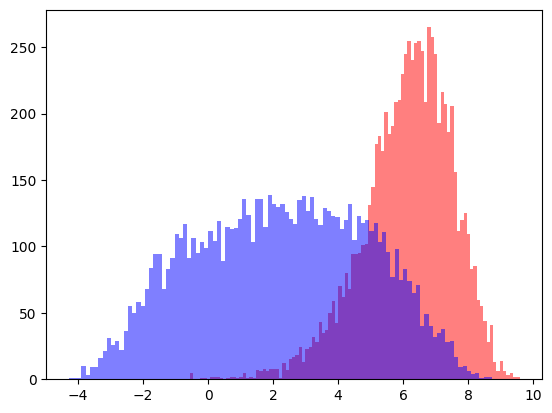

In [106]:
# y0, y1, delta = train_y0, train_y1, train_delta
y0, y1, delta = val_y0, val_y1, val_delta

_ = pyplot.hist(y0, bins=100, color='r', alpha=0.5)
_ = pyplot.hist(y1, bins=100, color='b', alpha=0.5)
# _ = pyplot.hist(delta, bins=100, color='g', alpha=0.5)

## cosine similarity within pairs

In [107]:
x = val_data
y = val_delta

norm0 = np.linalg.norm(x[..., 0], axis=-1)
norm1 = np.linalg.norm(x[..., 1], axis=-1)

dot_product = (x[..., 0] * x[..., 1]).sum(axis=-1)

cos = dot_product / (norm0 * norm1)

Text(0.5, 1.0, 'histogram of cosine similarity within pairs')

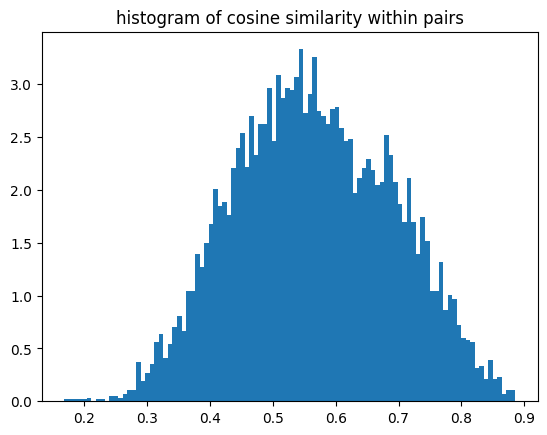

In [108]:
_ = pyplot.hist(cos, bins=100, density=True)
pyplot.title('histogram of cosine similarity within pairs')

Text(0, 0.5, 'score difference')

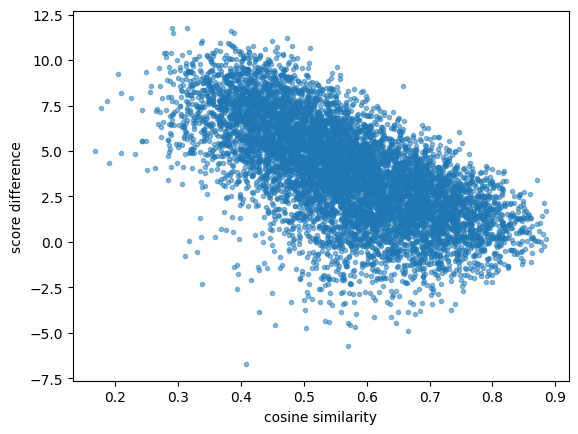

In [109]:
pyplot.plot(cos, y, '.', alpha=0.5)
pyplot.xlabel('cosine similarity')
pyplot.ylabel('score difference')

## distance between train and val set

In [110]:
train_flatten = np.concatenate([train_data[..., 0], train_data[..., 1]], axis=0)
val_flatten = np.concatenate([val_data[..., 0], val_data[..., 1]], axis=0)

In [111]:
cos_sim = cosine_similarity(train_flatten, val_flatten)
cos_sim = np.stack([
    cos_sim[:train_data.shape[0], :val_data.shape[0]], 
    cos_sim[:train_data.shape[0], val_data.shape[0]:], 
    cos_sim[train_data.shape[0]:, :val_data.shape[0]], 
    cos_sim[train_data.shape[0]:, val_data.shape[0]:], 
], axis=-1)

In [112]:
k = (np.stack([
    cos_sim[..., :2].max(axis=0).max(axis=-1),
    cos_sim[..., 2:].max(axis=0).max(axis=-1)
], axis=-1) > 0.9).sum(axis=-1)

np.unique(k, return_counts=True)

(array([0, 1, 2]), array([ 172, 1884, 5855]))

In [113]:
(val_delta[k == 0] > 0).mean()

0.9127906976744186

In [114]:
(val_delta[k == 1] > 0).mean()

0.8980891719745223

In [115]:
(val_delta[k == 2] > 0).mean()

0.9236549957301452

## score distribution

In [7]:
from utils import get_score_from_embs

In [12]:
score = get_score_from_embs(image_embeds.astype('float32'), model, batch_size=1024)

  0%|          | 0/75 [00:00<?, ?it/s]

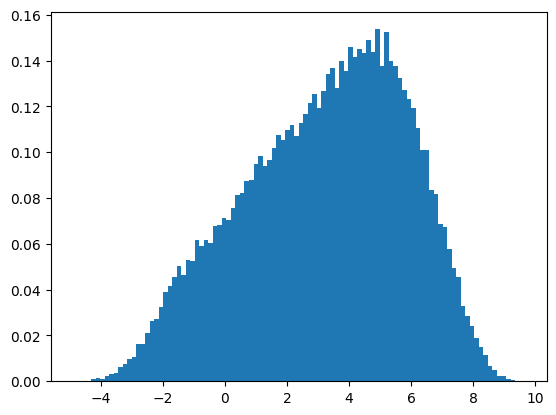

In [13]:
_ = pyplot.hist(score, bins=100, density=True)
pyplot.show()

## prepare for visualization

In [137]:
def select_samples(indices, n_select):
    
    selected = np.random.choice(indices, n_select, False)
    
    selected_file_paths = [file_paths[i] for i in selected]
    selected_file_paths = [i.split('_')[0] + '.jpg' for i in selected_file_paths]
    
    images = np.stack([np.array(Image.open(os.path.join('../kcg-ml-image-pipeline/output/dataset/image/', i))) for i in selected_file_paths])
    images = images.reshape(-1, int(n_select ** 0.5), *images.shape[-3:])
    images = np.concatenate(np.concatenate(images, axis=-3), axis=-2)
    
    images = Image.fromarray(images).resize((512, 512))
    
    return selected, images

## show top score samples

In [138]:
threshold = np.quantile(score, q=0.95)
selected, images = select_samples(np.arange(score.shape[0])[score > threshold], n_select=9)

threshold

7.078125

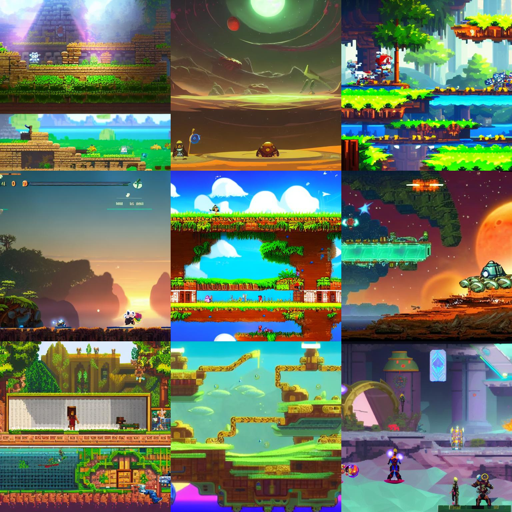

In [139]:
images

## show lowest score samples

In [140]:
threshold = np.quantile(score, q=0.05)
selected, images = select_samples(np.arange(score.shape[0])[score < threshold], n_select=9)

threshold

-1.455078125

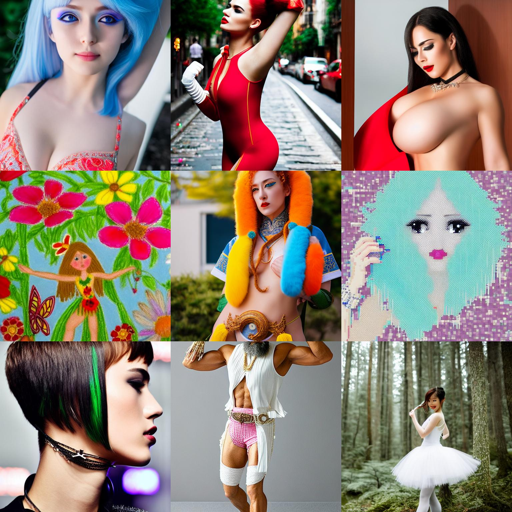

In [141]:
images

## show lowest delta samples

In [142]:
n_select = 6

# threshold = np.quantile(val_delta, q=0.05)
# indices = val_pairs.index[np.arange(val_delta.shape[0])[val_delta < threshold]]
# selected = np.random.choice(indices, n_select, False)

selected = val_pairs.index[np.argsort(val_delta)[:n_select]]

indices_1 = [path_to_index[i] for i in val_pairs.loc[selected, 'image_1']]
indices_2 = [path_to_index[i] for i in val_pairs.loc[selected, 'image_2']]

In [143]:
selected_file_paths = [file_paths[i] for i in indices_1]
selected_file_paths = [i.split('_')[0] + '.jpg' for i in selected_file_paths]

images = np.stack([np.array(Image.open(os.path.join('../kcg-ml-image-pipeline/output/dataset/image/', i))) for i in selected_file_paths])
images_1 = np.concatenate(images, axis=-2)

selected_file_paths = [file_paths[i] for i in indices_2]
selected_file_paths = [i.split('_')[0] + '.jpg' for i in selected_file_paths]

images = np.stack([np.array(Image.open(os.path.join('../kcg-ml-image-pipeline/output/dataset/image/', i))) for i in selected_file_paths])
images_2 = np.concatenate(images, axis=-2)

images = np.concatenate([images_1, images_2], axis=-3)

images = Image.fromarray(images).resize((512 * n_select // 2, 512))

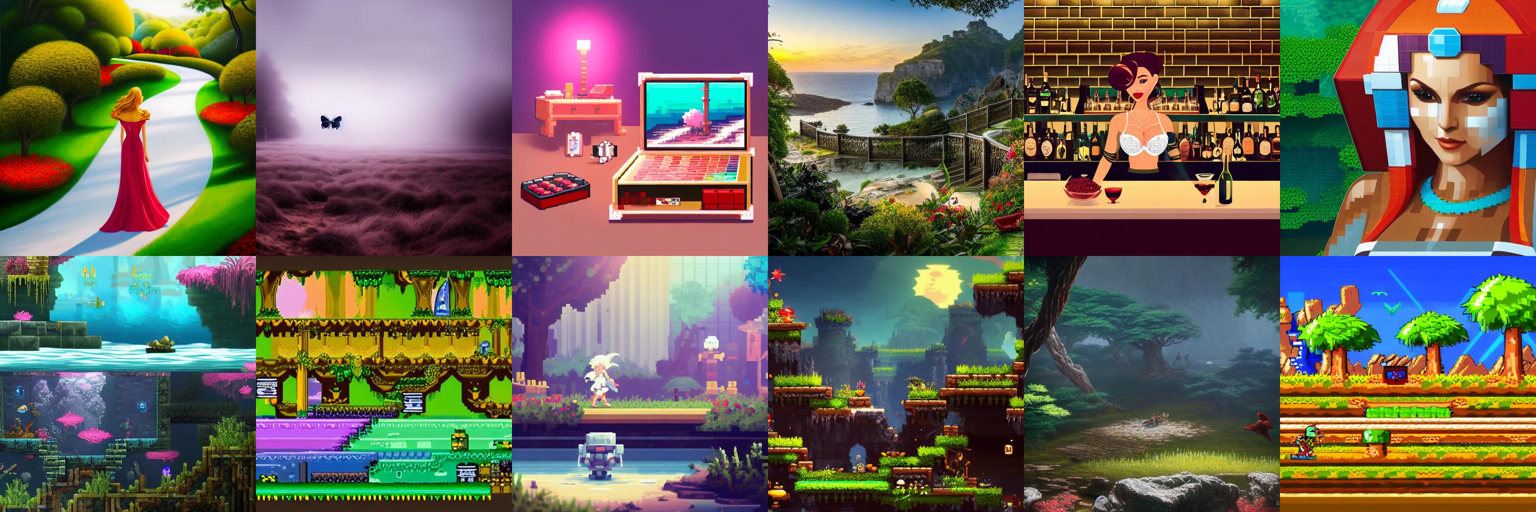

In [144]:
images